# Dipendenze

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install pillow numpy matplotlib tensorflow[and-cuda]

# Imports

In [1]:
import os
import time
import math
import zipfile
import random
import itertools
import pathlib
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import PIL.Image as pillow

2025-01-21 17:10:52.511319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737479452.528238   15417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737479452.533509   15417 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 17:10:52.555545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
print(f"TensorFlow version: {tf.__version__}")
for i, dev in enumerate(tf.config.list_physical_devices(device_type="GPU")):
    print(f"\t* Available {dev.device_type} #{i}: {dev.name}")

TensorFlow version: 2.18.0
	* Available GPU #0: /physical_device:GPU:0


# Estrazione del dataset

In [3]:
DATASET_ZIP_PATH="animals.zip"
DATASET_IMGS_DESTDIR="./"

if not os.path.isdir(DATASET_IMGS_DESTDIR + "animals"):
    if not os.path.isfile(DATASET_ZIP_PATH):
        raise FileNotFoundError(f" !! Unable to continue, could not find zipped dataset to extract dataset from: {DATASET_ZIP_PATH}")

    with zipfile.ZipFile(DATASET_ZIP_PATH, mode="r") as animalz:
        animalz.extractall(DATASET_IMGS_DESTDIR)

### Calcolo della media della dimensione delle immagini del dataset

In [4]:
ws = []
hs = []

start = time.time()

for root, dirs, files in os.walk(DATASET_IMGS_DESTDIR + "animals"):
    path = root.split(os.sep)
    for file in files:
        mypath = f"{DATASET_IMGS_DESTDIR}animals/{os.path.basename(root)}/{file}"
        img = pillow.open(mypath)
        w,h = img.size
        ws.append(w)
        hs.append(h)

avg = lambda n: sum(n) / len(n)

avg_w = int(avg(ws))
avg_h = int(avg(hs))

end = time.time()

print(f"done. it took {end - start:.2f} secs.\navg_w = {avg_w}, avg_h = {avg_h}")

done. it took 29.81 secs.
avg_w = 319, avg_h = 252


# Caricamento del dataset e split

In [5]:
INPUT_SHAPE=(avg_w, avg_w, 3)
BATCH_SIZE=16

training_set, testing_set = keras.utils.image_dataset_from_directory(
    DATASET_IMGS_DESTDIR + "animals",
    subset="both",
    seed=1234,
    validation_split=0.3,
    image_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    label_mode="categorical",
    batch_size=BATCH_SIZE)

training_set_size = int(0.8 * len(training_set))
validation_set_size = int(0.2 * len(training_set))
__Training_set = training_set.take(training_set_size)
validation_set = training_set.skip(training_set_size).take(validation_set_size)
training_set = __Training_set

print(f"num of training set batches: {len(training_set)} so {len(training_set) * BATCH_SIZE} elems")
print(f"num of validation set batches: {len(validation_set)} so {len(validation_set) * BATCH_SIZE} elems")
print(f"num of testing set batches: {len(testing_set)} so {len(testing_set) * BATCH_SIZE} elems")

dataset_labels = {
        0 : "cane",
        1 : "cavallo",
        2 : "elefante",
        3 : "farfalla",
        4 : "gallina",
        5 : "gatto",
        6 : "mucca",
        7 : "pecora",
        8 : "ragno",
        9 : "scoiattolo"
    }

Found 26128 files belonging to 10 classes.
Using 18290 files for training.
Using 7838 files for validation.


I0000 00:00:1737479496.713792   15417 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


num of training set batches: 915 so 14640 elems
num of validation set batches: 228 so 3648 elems
num of testing set batches: 490 so 7840 elems


# Costruzione del modello

## Helper per transfer learning

In [6]:
class TransferLearning:
    STR_NO_MODEL = "model has not been built"
    
    def __init__(self, base_model, user_name):
        self.base_model = base_model
        self.model = None
        self.full_name = f"{user_name}_{base_model().name}"
        self.weights_filename = f"./{self.full_name}_tl.weights.h5"
        self.user_name = user_name
        
    # you should not override this
    def load_weights_from_file(self):
        if self.model:
            if os.path.isfile(self.weights_filename):
                self.model.load_weights(self.weights_filename)
                print(f"loaded weights: {self.weights_filename}")
            else:
                raise FileNotFoundError(f"unable to load weights - cannot find: {self.weights_filename}")
        else:
            raise RuntimeError(STR_NO_MODEL)

    # you should not override this
    def save_weights_to_file(self):
        if self.model:
            self.model.save_weights(self.weights_filename)
            print(f"done: {self.weights_filename}")
        else:
            raise RuntimeError(STR_NO_MODEL)

    # you should not override this
    def build_model(self, *args, **kwargs):
        top_layers = 0

        def atlay(x):
            nonlocal top_layers
            top_layers += 1
            return x
        
        defd_model = self.__define_model(atlay, *args, **kwargs)
    
        freezing_layers = defd_model.layers[:len(defd_model.layers) - top_layers]
        for layer in freezing_layers:
            layer.trainable = False

        self.model = defd_model

    # you may override this
    # private (let's say "protected")
    def __define_model(self, add_top_layer, *args, **kwargs):
        return keras.Sequential([
                keras.Input(shape=args[0]),
                keras.layers.Rescaling(scale=1./127.5, offset=-1),
                self.base_model(include_top=False, input_shape=args[0]),
                add_top_layer(keras.layers.GlobalAveragePooling2D()),
                add_top_layer(keras.layers.Dropout(0.25)),
                add_top_layer(keras.layers.Dense(
                    10,
                    bias_initializer=keras.initializers.GlorotUniform(),
                    activation=keras.activations.softmax))
                ], name=self.user_name)

    # you may override this
    def compile_model(self, *args, **kwargs):
        self.model.compile(
                optimizer=keras.optimizers.Adam(),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[
                    keras.metrics.CategoricalAccuracy()
                ])

    # you may override this
    def fit_model(self, *args, **kwargs):
        return self.model.fit(
                args[0],
                validation_data=args[1],
                validation_freq=3,
                epochs=40,
                callbacks=[
                    keras.callbacks.EarlyStopping(
                        start_from_epoch=3,
                        patience=2,
                        restore_best_weights=True),
                    keras.callbacks.LearningRateScheduler(
                        lambda e, l: l if e < 1 else l * np.exp(-0.15)
                )])

## Build

In [7]:
tl_main = TransferLearning(keras.applications.MobileNet, "main_model")
tl_main.build_model(INPUT_SHAPE)
tl_main.model.summary()

/tmp/ipykernel_15417/3408859375.py:53: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  self.base_model(include_top=False, input_shape=args[0]),


Model: "main_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 319, 319, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 10, 10, 1024)   │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

## Ripristino dei pesi da file (se presenti)

In [8]:
try:
    tl_main.load_weights_from_file()
except FileNotFoundError as e:
    print(e)

loaded weights: ./main_model_mobilenet_1.00_224_tl.weights.h5


# Addestramento del modello

## Transfer learning

In [17]:
tl_main.compile_model()
tl_main.fit_model(training_set, validation_set)

Epoch 1/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - categorical_accuracy: 0.7744 - loss: 0.7237 - learning_rate: 0.0010
Epoch 2/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - categorical_accuracy: 0.9467 - loss: 0.1766 - learning_rate: 8.6071e-04
Epoch 3/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - categorical_accuracy: 0.9556 - loss: 0.1448 - val_categorical_accuracy: 0.9663 - val_loss: 0.1278 - learning_rate: 7.4082e-04
Epoch 4/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - categorical_accuracy: 0.9618 - loss: 0.1247 - learning_rate: 6.3763e-04
Epoch 5/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - categorical_accuracy: 0.9644 - loss: 0.1178 - learning_rate: 5.4881e-04
Epoch 6/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - categorical_accuracy: 0.9663 - loss: 0.1123 - val_categorical_accuracy: 0.9679 - val_loss: 0.1133 - learning_rate: 4.7237e-04
Epoch 7/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - categorical_accuracy: 0.9672 - loss: 0.1027 - learning_rate: 4.0657e-04


## Salvataggio pesi correnti

In [18]:
tl_main.save_weights_to_file()

done: ./main_model_mobilenet_1.00_224_tl.weights.h5


# Provare a fare predizioni

In [9]:
def __base_predict_3x3_from_dataset__(dataset, m, predict_hook):
    shuffled_dataset = dataset.unbatch().shuffle(buffer_size=10)
    plt.figure(figsize=(10, 10))
    for i, t in itertools.islice(enumerate(shuffled_dataset), 0, 9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(t[0].numpy().astype("uint8"))
        y = predict_hook(t[0], m)
        plt.title(dataset_labels[np.argmax(y)])
        plt.axis("off")

In [10]:
def predict_3x3_from_dataset(dataset, modl):
    def predict(images, m):
        resized = tf.image.resize([images], (INPUT_SHAPE[0], INPUT_SHAPE[1]))
        inputs = tf.reshape(resized, (1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
        return m.predict(inputs)
        
    __base_predict_3x3_from_dataset__(
        dataset,
        modl,
        predict)

I0000 00:00:1737479523.063144   15504 service.cc:148] XLA service 0x7f99680214c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737479523.063190   15504 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-01-21 17:12:03.084411: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737479523.251060   15504 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1737479524.037506   15504 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737479524.160210   15504 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737479524.286746   15504

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

I0000 00:00:1737479525.727583   15504 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


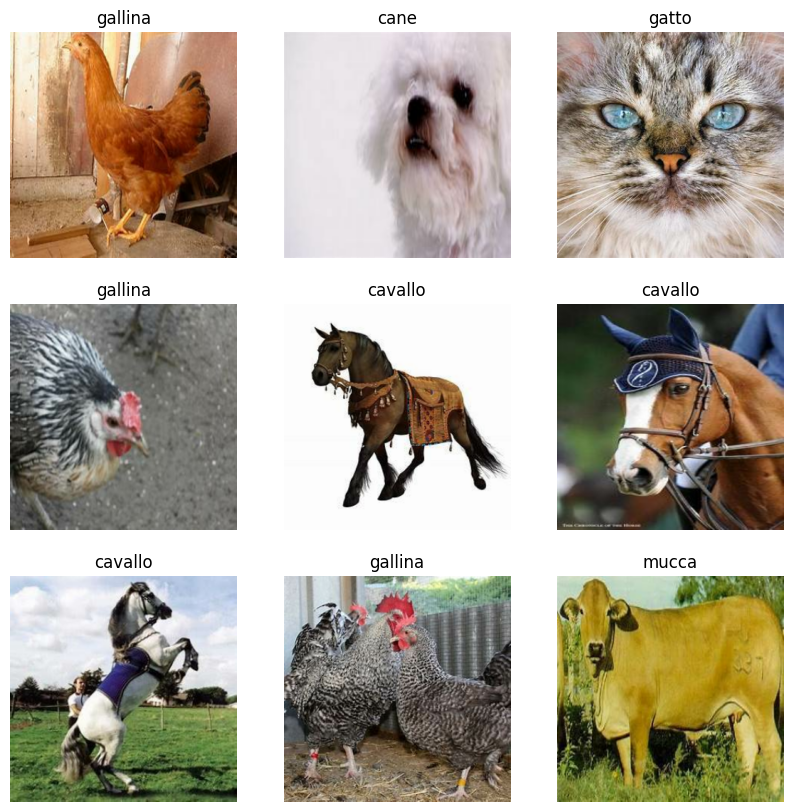

In [11]:
predict_3x3_from_dataset(validation_set, tl_main.model)

# Applicazione della quantizzazione

## Helpers per TensorFlow Lite / LiteRT

In [12]:
class TFLiteUtils:
    @staticmethod
    def preprocess(image):
        image = tf.image.resize(image, (avg_w, avg_w))
        return image
        
    @staticmethod
    def predict(tflite_file, img, audit=True):
        interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
        interpreter.allocate_tensors()

        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]
        
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            img = img / input_scale + input_zero_point
            
        _img = np.expand_dims(img, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], _img)

        start = 0
        end = 0

        if audit:
            start = time.perf_counter()

        interpreter.invoke()

        if audit:
            end = time.perf_counter()

        if audit:
            print(f"hres-timer inference time elapsed wall clock: {math.ceil((end - start) * 1000)}ms")
        
        return interpreter.get_tensor(output_details["index"])[0]

    @staticmethod
    def evaluate(tflite_file, dataset, batch_size=BATCH_SIZE, log_every=150):
        def log_eval_stats_sofar(end_trecord):
            print(f"evaluating tflite model - "+
                  f"{i+1}/{total_evals} ({math.floor(((i+1)/total_evals) * 100)}%) - " + 
                  f"cce_loss: {kcce(acc_ts, acc_ys):.4f}, " +
                  f"ca_metric: {kca.result():.4f} - "+
                  f"elapsed wall clock time: {end_trecord - start:.2f}s ", end="\r")
            
        acc_ys = []
        acc_ts = []

        audit = log_every > 0
        
        total_evals = batch_size * len(dataset)
        kca = keras.metrics.CategoricalAccuracy()
        kcce = keras.losses.CategoricalCrossentropy()

        if audit:
            print("preparing, please wait...", end="\r")

        start = 0
            
        for i, e in enumerate(dataset.unbatch()):
            if i == 0:
                start = time.time()
                if audit:
                    print("evaluation has started (timer *now* ticking), stats will be available asap...", end="\r")
                
            y = TFLiteUtils.predict(tflite_file, TFLiteUtils.preprocess(e[0]), False)
            
            acc_ys.append(y)
            acc_ts.append(e[1])
            kca.update_state([e[1]], [y])

            if audit and (i+1) % log_every == 0:
                log_eval_stats_sofar(time.time())

        end = time.time()
        
        if audit:
            log_eval_stats_sofar(end)
            print("")

        return float(kcce(acc_ts, acc_ys)), float(kca.result()), end - start

    @staticmethod
    def get_model_path(tflite_model_name):
        tflite_models_dir = pathlib.Path("./")
        tflite_models_dir.mkdir(exist_ok=True, parents=True)
        return tflite_models_dir/f"{tflite_model_name}.tflite"

    @staticmethod
    def save_tofile(tflite_model_name, tflite_model):
        path = TFLiteUtils.get_model_path(tflite_model_name)
        path.write_bytes(tflite_model)
        print(f"saved tflite model: {str(path)}")
        return str(path)

    class Conversion:
        get_basic_name = lambda your_name : f"{your_name}_basic"
        get_weights_only_name = lambda your_name : f"{your_name}_weights_only"
        get_partially_full_name = lambda your_name : f"{your_name}_partially_full"
        get_full_name = lambda your_name : f"{your_name}_full"
        
        #private
        @staticmethod
        def __representative_data_gen(trset):
            for xinput, _ in trset.unbatch().take(100):
                yield [tf.expand_dims(xinput, axis=0)]

        # no quantization applied here
        @staticmethod
        def basic(keras_model):
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            return converter.convert()

        @staticmethod
        def weights_only_quant(keras_model):
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            return converter.convert()
            
        @staticmethod
        def partially_full_quant(keras_model, trset):
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.representative_dataset = lambda : TFLiteUtils.Conversion.__representative_data_gen(trset)

            return converter.convert()
            
        @staticmethod
        def full_quant(keras_model, trset):
            converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.representative_dataset = lambda : TFLiteUtils.Conversion.__representative_data_gen(trset)
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.uint8
            converter.inference_output_type = tf.uint8
            
            return converter.convert()

def predict_3x3_from_dataset_tflite(dataset, modl):
    def predict(i, m):
        return TFLiteUtils.predict(TFLiteUtils.get_model_path(m), TFLiteUtils.preprocess(i.numpy()))
        
    __base_predict_3x3_from_dataset__(
        dataset,
        modl,
        predict)

## Quantizzazione (dal livello più debole a quello più forte)

In [13]:
main_basic_tflite = TFLiteUtils.Conversion.basic(tl_main.model)
TFLiteUtils.save_tofile(TFLiteUtils.Conversion.get_basic_name(tl_main.full_name), main_basic_tflite)

INFO:tensorflow:Assets written to: /tmp/tmp0higxbr8/assets


INFO:tensorflow:Assets written to: /tmp/tmp0higxbr8/assets


Saved artifact at '/tmp/tmp0higxbr8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 319, 319, 3), dtype=tf.float32, name='keras_tensor_91')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140300227504720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227506448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227509712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227507408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227510096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227509904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227507792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1403007369

W0000 00:00:1737479545.372363   15417 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737479545.372398   15417 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 17:12:25.372702: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0higxbr8
2025-01-21 17:12:25.376515: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 17:12:25.376528: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp0higxbr8
I0000 00:00:1737479545.417691   15417 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-21 17:12:25.425896: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 17:12:25.703456: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp0higxbr8
2025-01-21 17:12:25.775827: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

'main_model_mobilenet_1.00_224_basic.tflite'

In [14]:
main_weights_only_quant_tflite = TFLiteUtils.Conversion.weights_only_quant(tl_main.model)
TFLiteUtils.save_tofile(TFLiteUtils.Conversion.get_weights_only_name(tl_main.full_name), main_weights_only_quant_tflite)

INFO:tensorflow:Assets written to: /tmp/tmp8f51m9rf/assets


INFO:tensorflow:Assets written to: /tmp/tmp8f51m9rf/assets


Saved artifact at '/tmp/tmp8f51m9rf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 319, 319, 3), dtype=tf.float32, name='keras_tensor_91')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140300227504720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227506448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227509712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227507408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227510096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227509904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227507792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1403007369

W0000 00:00:1737479549.627467   15417 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737479549.627504   15417 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 17:12:29.627654: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8f51m9rf
2025-01-21 17:12:29.631595: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 17:12:29.631607: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8f51m9rf
2025-01-21 17:12:29.684277: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 17:12:29.960448: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp8f51m9rf
2025-01-21 17:12:30.035057: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 407406 microseconds.


'main_model_mobilenet_1.00_224_weights_only.tflite'

In [15]:
main_partially_full_quant_tflite = TFLiteUtils.Conversion.partially_full_quant(tl_main.model, training_set)
TFLiteUtils.save_tofile(TFLiteUtils.Conversion.get_partially_full_name(tl_main.full_name), main_partially_full_quant_tflite)

INFO:tensorflow:Assets written to: /tmp/tmp5ee1e9ex/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ee1e9ex/assets


Saved artifact at '/tmp/tmp5ee1e9ex'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 319, 319, 3), dtype=tf.float32, name='keras_tensor_91')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140300227504720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227506448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227509712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227507408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227510096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227509904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227507792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1403007369

/home/jupyter/.local/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1737479554.054738   15417 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737479554.054773   15417 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 17:12:34.054928: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5ee1e9ex
2025-01-21 17:12:34.059949: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 17:12:34.059963: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp5ee1e9ex
2025-01-21 17:12:34.110749: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 17:12:34.388796: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp5ee

saved tflite model: main_model_mobilenet_1.00_224_partially_full.tflite


'main_model_mobilenet_1.00_224_partially_full.tflite'

In [16]:
main_full_quant_tflite = TFLiteUtils.Conversion.full_quant(tl_main.model, training_set)
TFLiteUtils.save_tofile(TFLiteUtils.Conversion.get_full_name(tl_main.full_name), main_full_quant_tflite)

INFO:tensorflow:Assets written to: /tmp/tmp3yd8jt7g/assets


INFO:tensorflow:Assets written to: /tmp/tmp3yd8jt7g/assets


Saved artifact at '/tmp/tmp3yd8jt7g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 319, 319, 3), dtype=tf.float32, name='keras_tensor_91')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140300227504720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227508368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227506448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227509712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227507408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227510096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227509904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140300227507792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1403007369

/home/jupyter/.local/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1737479567.985246   15417 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737479567.985281   15417 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-21 17:12:47.985432: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3yd8jt7g
2025-01-21 17:12:47.990644: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-21 17:12:47.990658: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp3yd8jt7g
2025-01-21 17:12:48.043670: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-21 17:12:48.322334: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp3yd

saved tflite model: main_model_mobilenet_1.00_224_full.tflite


'main_model_mobilenet_1.00_224_full.tflite'